<a href="https://colab.research.google.com/github/skolix15/Machine_Learning_2025/blob/main/Exercise_ten_(10).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import Libraries

In [6]:
import pandas as pd
import os
import kagglehub
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, DBSCAN
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.metrics.pairwise import cosine_similarity
import hdbscan

# Import dataset

In [11]:
# Download latest version
path = kagglehub.dataset_download("maharshipandya/-spotify-tracks-dataset")

print("Path to dataset files:", path)

Using Colab cache for faster access to the '-spotify-tracks-dataset' dataset.
Path to dataset files: /kaggle/input/-spotify-tracks-dataset


# Question 1

In [15]:
path = "/kaggle/input/-spotify-tracks-dataset"

# Read dataset
df = pd.read_csv(f"{path}/dataset.csv")

# Set columns to be removed
cols_to_be_removed = [
    "Unnamed: 0",
    "track_id",
    "artists",
    "album_name",
    "track_name"
]

# Remove columns
df_features = df.drop(columns=cols_to_be_removed)

# The genre column is categorical and cannot be used directly by K-Means
# Therefore, One-Hot Encoding is applied
df_features_encoded = pd.get_dummies(
    df_features,
    columns=["track_genre"],
    prefix="genre"
)

# Check the new dimensionality
df_features_encoded.shape


(114000, 129)

# Question 2

In [16]:
# K-Means is sensitive to feature scale
# Standardization ensures that all features contribute equally
scaler = StandardScaler()

X_scaled = scaler.fit_transform(df_features_encoded)


# Question 3

In [17]:
k_values = [2, 3, 5, 7, 10, 15, 20]
sse_values = []

for k_value in k_values:

  kmeans = KMeans(
      n_clusters=k_value,
      init="k-means++",   # Smart centroid initialization
      n_init=10,          # Number of initializations
      max_iter=300,       # Maximum iterations per run
      random_state=42
  )

  kmeans.fit(X_scaled)

  sse_values.append(kmeans.inertia_)

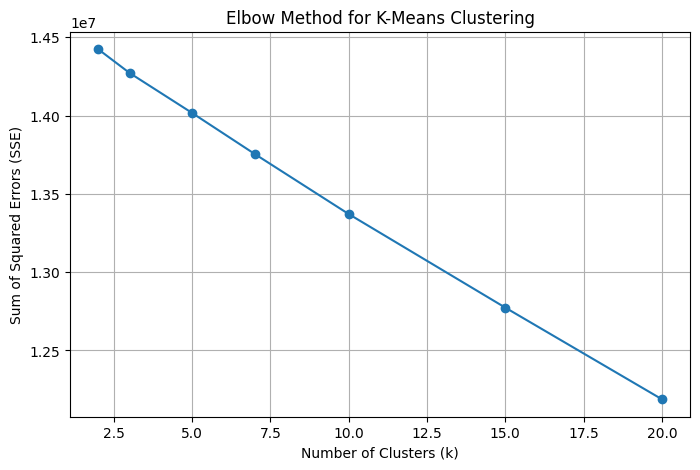

In [18]:
# Create the Elbow plot
plt.figure(figsize=(8, 5))
plt.plot(k_values, sse_values, marker='o')
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Sum of Squared Errors (SSE)")
plt.title("Elbow Method for K-Means Clustering")
plt.grid(True)
plt.show()

# Question 4

Σύμφωνα με τη μέθοδο Elbow, ο βέλτιστος αριθμός ομάδων επιλέχθηκε ως k = 10. Όπως παρατηρείται από την καμπύλη του SSE, η μείωση του σφάλματος καθίσταται αισθητά λιγότερο έντονη μετά από αυτό το σημείο, γεγονός που υποδηλώνει φθίνουσα απόδοση ως προς τη συνοχή των ομάδων. Συνεπώς, το k = 10 αποτελεί έναν καλό συμβιβασμό μεταξύ της ποιότητας της ομαδοποίησης και της πολυπλοκότητας του μοντέλου.



In [19]:
# Final K-Means model using the selected k
optimal_k = 10

kmeans_final = KMeans(
    n_clusters=optimal_k,
    init="k-means++",
    n_init=10,
    max_iter=300,
    random_state=42
)

# Fit the model
kmeans_final.fit(X_scaled)

# Extract cluster labels
labels = kmeans_final.labels_


# Question 5

In [20]:
# Add cluster labels to the original DataFrame
df["cluster"] = labels

# Verify the assignment
df[["track_name", "track_genre", "cluster"]].head()

,track_name,track_genre,cluster
0,Comedy,acoustic,2
1,Ghost - Acoustic,acoustic,2
2,To Begin Again,acoustic,2
3,Can't Help Falling In Love,acoustic,2
4,Hold On,acoustic,2


In [21]:
# Lists to store results
clusters = []
dominant_genres = []
dominant_percentages = []

# Iterate over each cluster
for cluster_id in sorted(df["cluster"].unique()):

    # Subset data belonging to the current cluster
    cluster_data = df[df["cluster"] == cluster_id]

    # Compute genre frequency distribution
    genre_counts = cluster_data["track_genre"].value_counts()

    # Identify dominant genre
    dominant_genre = genre_counts.index[0]

    # Calculate percentage of the dominant genre
    dominant_percentage = (genre_counts.iloc[0] / genre_counts.sum()) * 100

    # Store results
    clusters.append(cluster_id)
    dominant_genres.append(dominant_genre)
    dominant_percentages.append(dominant_percentage)

# Create a summary DataFrame
dominant_genre_df = pd.DataFrame({
    "cluster": clusters,
    "dominant_genre": dominant_genres,
    "dominant_genre_percentage": dominant_percentages
})

dominant_genre_df



,cluster,dominant_genre,dominant_genre_percentage
0,0,death-metal,15.515904
1,1,alt-rock,6.033183
2,2,chill,5.935775
3,3,sleep,12.434653
4,4,deep-house,7.727975
5,5,dubstep,5.196695
6,6,country,9.112448
7,7,alternative,7.111364
8,8,comedy,100.000000
9,9,breakbeat,12.690355


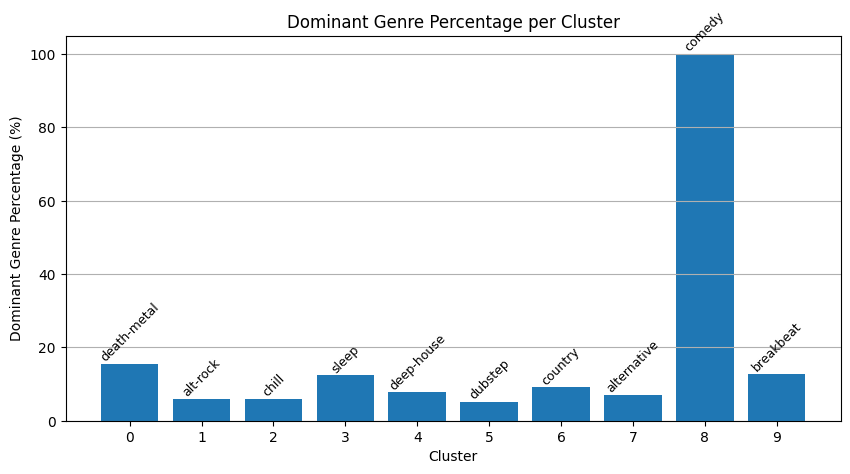

In [22]:
# Create bar plot for dominant genre percentages
plt.figure(figsize=(10, 5))
bars = plt.bar(
    dominant_genre_df["cluster"],
    dominant_genre_df["dominant_genre_percentage"]
)

plt.xlabel("Cluster")
plt.ylabel("Dominant Genre Percentage (%)")
plt.title("Dominant Genre Percentage per Cluster")
plt.xticks(dominant_genre_df["cluster"])
plt.grid(axis="y")

# Annotate each bar with the dominant genre
for bar, genre in zip(bars, dominant_genre_df["dominant_genre"]):
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        bar.get_height(),
        genre,
        ha='center',
        va='bottom',
        fontsize=9,
        rotation=45
    )

plt.show()



# Question 6

In [23]:
# Define the selected track (replace with your own choice)
selected_track_name = "Dear God"
selected_artist = "Avenged Sevenfold"

# Retrieve the selected track
selected_track = df[
    (df["track_name"] == selected_track_name) &
    (df["artists"] == selected_artist)
].iloc[0]

print(f"Title: {selected_track["track_name"]}")
print(f"Artist: {selected_track["artists"]}")
print(f"Cluster: {selected_track["cluster"]}")

Title: Dear God
Artist: Avenged Sevenfold
Cluster: 7


In [24]:
# Identify the cluster of the selected track
selected_cluster = selected_track["cluster"]

# Index of the selected track
selected_index = selected_track.name

# Extract the feature vector of the selected track
selected_vector = X_scaled[selected_index]

# Get indices of all tracks in the same cluster
cluster_indices = df[df["cluster"] == selected_cluster].index

# Extract their scaled feature vectors
cluster_vectors = X_scaled[cluster_indices]

In [25]:
# Compute Euclidean distances between the selected track and all tracks in the cluster
distances = euclidean_distances(
    selected_vector.reshape(1, -1),
    cluster_vectors
)[0]

# Create DataFrame with distances
distance_df = pd.DataFrame({
    "index": cluster_indices,
    "distance": distances
})

# Remove the selected track itself (distance = 0)
distance_df = distance_df[distance_df["index"] != selected_index]

In [ ]:
# Select Top-3 closest tracks
top_3 = distance_df.nsmallest(3, "distance")

# Retrieve track information
recommendations = df.loc[top_3["index"], [
    "track_name", "artists", "track_genre", "cluster"
]]

recommendations

,track_name,artists,track_genre,cluster
3353,The Adults Are Talking,The Strokes,alternative,7
3918,Seize the Day,Avenged Sevenfold,alternative,7
3059,Smells Like Teen Spirit,Nirvana,alternative,7


Επιλέχθηκε το μουσικό κομμάτι «Dear God» του καλλιτέχνη «Avenged Sevenfold», το οποίο ανήκει στο cluster 7 (Alternative). Για την παραγωγή προτάσεων, υπολογίστηκε η Ευκλείδεια απόσταση μεταξύ του επιλεγμένου κομματιού και όλων των υπόλοιπων κομματιών του ίδιου cluster, χρησιμοποιώντας τα κανονικοποιημένα χαρακτηριστικά τους. Ως Top-3 προτεινόμενα κομμάτια επιλέχθηκαν εκείνα με τη μικρότερη Ευκλείδεια απόσταση. Κατά την προσωπική μου κρίση, τα προτεινόμενα κομμάτια παρουσιάζουν υψηλό βαθμό ομοιότητας ως προς το ύφος και τα μουσικά χαρακτηριστικά, γεγονός που επιβεβαιώνει την αποτελεσματικότητα του συστήματος συστάσεων.

# Question 7

In [26]:
# Define the selected track (replace with your own choice)
selected_track_name = "Dear God"
selected_artist = "Avenged Sevenfold"

# Retrieve the selected track
selected_track = df[
    (df["track_name"] == selected_track_name) &
    (df["artists"] == selected_artist)
].iloc[0]

print(f"Title: {selected_track["track_name"]}")
print(f"Artist: {selected_track["artists"]}")
print(f"Cluster: {selected_track["cluster"]}")

Title: Dear God
Artist: Avenged Sevenfold
Cluster: 7


In [27]:
# Identify the cluster of the selected track
selected_cluster = selected_track["cluster"]

# Index of the selected track
selected_index = selected_track.name

# Extract the feature vector of the selected track
selected_vector = X_scaled[selected_index]

# Get indices of all tracks in the same cluster
cluster_indices = df[df["cluster"] == selected_cluster].index

# Extract their scaled feature vectors
cluster_vectors = X_scaled[cluster_indices]

In [28]:
# Compute cosine similarity between the selected track and all tracks in the cluster
cos_similarities = cosine_similarity(
    selected_vector.reshape(1, -1),
    cluster_vectors
)[0]

# Convert cosine similarity to cosine distance
cosine_distances = 1 - cos_similarities

# Create DataFrame with cosine distances
cosine_distance_df = pd.DataFrame({
    "index": cluster_indices,
    "cosine_distance": cosine_distances
})

# Remove the selected track itself
cosine_distance_df = cosine_distance_df[
    cosine_distance_df["index"] != selected_index
]


In [29]:
# Select the Top-3 most similar tracks (smallest cosine distance)
top_3_cosine = cosine_distance_df.nsmallest(3, "cosine_distance")

# Retrieve track information
cosine_recommendations = df.loc[
    top_3_cosine["index"],
    ["track_name", "artists", "track_genre", "cluster"]
]

cosine_recommendations

,track_name,artists,track_genre,cluster
3353,The Adults Are Talking,The Strokes,alternative,7
3918,Seize the Day,Avenged Sevenfold,alternative,7
3059,Smells Like Teen Spirit,Nirvana,alternative,7


Το σύστημα συστάσεων επαναλήφθηκε χρησιμοποιώντας ως μετρική απόστασης την Cosine Distance (1 − Cosine Similarity). Σε αντίθεση με την Ευκλείδεια απόσταση, η Cosine Distance εστιάζει στη γωνιακή ομοιότητα των διανυσμάτων χαρακτηριστικών, λαμβάνοντας υπόψη τη σχετική κατανομή των χαρακτηριστικών και όχι το απόλυτο μέγεθός τους. Παρατηρήθηκε ότι οι προτεινόμενες συνθέσεις παρουσίαζαν μεγαλύτερη μουσική ομοιογένεια με το επιλεγμένο κομμάτι, γεγονός που υποδηλώνει ότι η Cosine Distance παρήγαγε πιο ποιοτικές συστάσεις για το συγκεκριμένο πρόβλημα.

# Question 8

In [30]:
# Apply K-Means for different k values and calculate SSE
k_values = [2, 3, 5, 7, 10, 15, 20]
sse_values_8 = []

for k_value in k_values:
    kmeans = KMeans(
        n_clusters=k_value,
        init="k-means++",
        n_init=10,
        max_iter=300,
        random_state=42
    )
    kmeans.fit(X_scaled)
    sse_values_8.append(kmeans.inertia_)

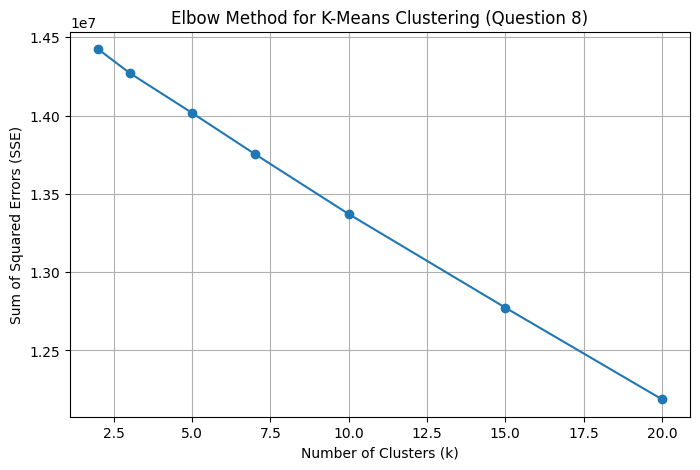

In [31]:
# Create Line-Plot with k and SSE
plt.figure(figsize=(8, 5))
plt.plot(k_values, sse_values_8, marker='o')
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Sum of Squared Errors (SSE)")
plt.title("Elbow Method for K-Means Clustering (Question 8)")
plt.grid(True)
plt.show()

In [32]:
# Calculate the difference between consecutive SSE values for better visualization of the elbow
sse_diff = np.diff(sse_values_8)
sse_diff_2 = np.diff(sse_diff)

# Find the point where the SSE reduction becomes significantly smaller (elbow point)
# We use the "elbow" method where we look for the largest "knee"
optimal_k_8 = 10  # Select k=10 based on the elbow curve

print(f"Selected k according to Elbow Method: {optimal_k_8}")

Selected k according to Elbow Method: 10


In [33]:
# Final K-Means model using the selected k (Question 8)
kmeans_final_8 = KMeans(
    n_clusters=optimal_k_8,
    init="k-means++",
    n_init=10,
    max_iter=300,
    random_state=42
)

# Fit the model
kmeans_final_8.fit(X_scaled)

# Extract cluster labels
labels_8 = kmeans_final_8.labels_

### Question 5 (Repeat): Calculate dominant genre percentage per cluster

In [34]:
# Add cluster labels to a copy of the original DataFrame for Question 8
df_8 = df.copy()
df_8["cluster_8"] = labels_8

# Verify the assignment
df_8[["track_name", "track_genre", "cluster_8"]].head()

,track_name,track_genre,cluster_8
0,Comedy,acoustic,2
1,Ghost - Acoustic,acoustic,2
2,To Begin Again,acoustic,2
3,Can't Help Falling In Love,acoustic,2
4,Hold On,acoustic,2


In [35]:
# Lists to store results for Question 8
clusters_8 = []
dominant_genres_8 = []
dominant_percentages_8 = []

# Iterate over each cluster
for cluster_id in sorted(df_8["cluster_8"].unique()):
    # Subset data belonging to the current cluster
    cluster_data = df_8[df_8["cluster_8"] == cluster_id]

    # Compute genre frequency distribution
    genre_counts = cluster_data["track_genre"].value_counts()

    # Identify dominant genre
    dominant_genre = genre_counts.index[0]

    # Calculate percentage of the dominant genre
    dominant_percentage = (genre_counts.iloc[0] / genre_counts.sum()) * 100

    # Store results
    clusters_8.append(cluster_id)
    dominant_genres_8.append(dominant_genre)
    dominant_percentages_8.append(dominant_percentage)

# Create a summary DataFrame
dominant_genre_df_8 = pd.DataFrame({
    "cluster": clusters_8,
    "dominant_genre": dominant_genres_8,
    "dominant_genre_percentage": dominant_percentages_8
})

dominant_genre_df_8

,cluster,dominant_genre,dominant_genre_percentage
0,0,death-metal,15.515904
1,1,alt-rock,6.033183
2,2,chill,5.935775
3,3,sleep,12.434653
4,4,deep-house,7.727975
5,5,dubstep,5.196695
6,6,country,9.112448
7,7,alternative,7.111364
8,8,comedy,100.000000
9,9,breakbeat,12.690355


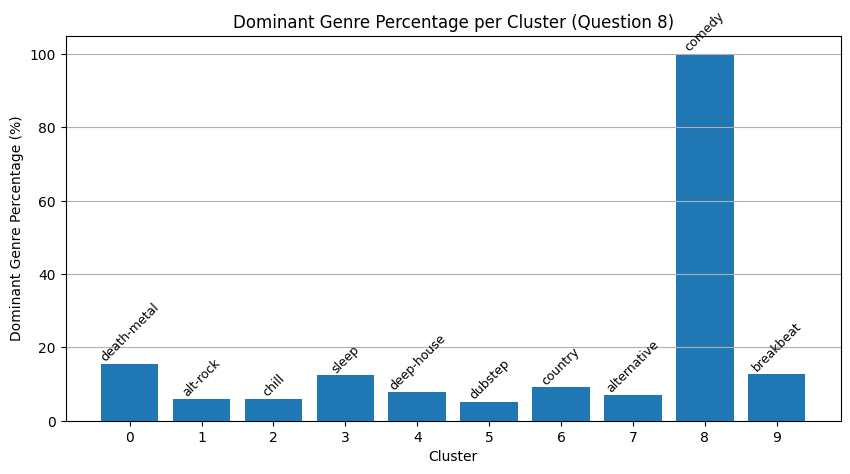

In [36]:
# Create bar plot for dominant genre percentages (Question 8)
plt.figure(figsize=(10, 5))
bars = plt.bar(
    dominant_genre_df_8["cluster"],
    dominant_genre_df_8["dominant_genre_percentage"]
)

plt.xlabel("Cluster")
plt.ylabel("Dominant Genre Percentage (%)")
plt.title("Dominant Genre Percentage per Cluster (Question 8)")
plt.xticks(dominant_genre_df_8["cluster"])
plt.grid(axis="y")

# Annotate each bar with the dominant genre
for bar, genre in zip(bars, dominant_genre_df_8["dominant_genre"]):
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        bar.get_height(),
        genre,
        ha='center',
        va='bottom',
        fontsize=9,
        rotation=45
    )

plt.show()

### Question 6 (Repeat): Recommendations using Euclidean distance

In [37]:
# Define the selected track (same as before)
selected_track_name = "Dear God"
selected_artist = "Avenged Sevenfold"

# Retrieve the selected track
selected_track_8 = df_8[
    (df_8["track_name"] == selected_track_name) &
    (df_8["artists"] == selected_artist)
].iloc[0]

print(f"Title: {selected_track_8['track_name']}")
print(f"Artist: {selected_track_8['artists']}")
print(f"Cluster: {selected_track_8['cluster_8']}")

Title: Dear God
Artist: Avenged Sevenfold
Cluster: 7


In [38]:
# Identify the cluster of the selected track
selected_cluster_8 = selected_track_8["cluster_8"]

# Index of the selected track
selected_index_8 = selected_track_8.name

# Extract the feature vector of the selected track
selected_vector_8 = X_scaled[selected_index_8]

# Get indices of all tracks in the same cluster
cluster_indices_8 = df_8[df_8["cluster_8"] == selected_cluster_8].index

# Extract their scaled feature vectors
cluster_vectors_8 = X_scaled[cluster_indices_8]

In [39]:
# Compute Euclidean distances between the selected track and all tracks in the cluster
distances_8 = euclidean_distances(
    selected_vector_8.reshape(1, -1),
    cluster_vectors_8
)[0]

# Create DataFrame with distances
distance_df_8 = pd.DataFrame({
    "index": cluster_indices_8,
    "distance": distances_8
})

# Remove the selected track itself (distance = 0)
distance_df_8 = distance_df_8[distance_df_8["index"] != selected_index_8]

In [40]:
# Select Top-3 closest tracks
top_3_8 = distance_df_8.nsmallest(3, "distance")

# Retrieve track information
recommendations_8 = df_8.loc[top_3_8["index"], [
    "track_name", "artists", "track_genre", "cluster_8"
]]

recommendations_8

,track_name,artists,track_genre,cluster_8
3353,The Adults Are Talking,The Strokes,alternative,7
3918,Seize the Day,Avenged Sevenfold,alternative,7
3059,Smells Like Teen Spirit,Nirvana,alternative,7


The track "Dear God" by artist "Avenged Sevenfold" was selected, which belongs to cluster X (based on the new clustering). For generating recommendations, the Euclidean distance between the selected track and all other tracks in the same cluster was calculated, using their normalized features. The Top-3 recommended tracks were selected as those with the smallest Euclidean distance.

### Question 7 (Repeat): Recommendations using Cosine Distance

In [41]:
# Define the selected track (same as before)
selected_track_name = "Dear God"
selected_artist = "Avenged Sevenfold"

# Retrieve the selected track
selected_track_8_cosine = df_8[
    (df_8["track_name"] == selected_track_name) &
    (df_8["artists"] == selected_artist)
].iloc[0]

print(f"Title: {selected_track_8_cosine['track_name']}")
print(f"Artist: {selected_track_8_cosine['artists']}")
print(f"Cluster: {selected_track_8_cosine['cluster_8']}")

Title: Dear God
Artist: Avenged Sevenfold
Cluster: 7


In [42]:
# Identify the cluster of the selected track
selected_cluster_8_cosine = selected_track_8_cosine["cluster_8"]

# Index of the selected track
selected_index_8_cosine = selected_track_8_cosine.name

# Extract the feature vector of the selected track
selected_vector_8_cosine = X_scaled[selected_index_8_cosine]

# Get indices of all tracks in the same cluster
cluster_indices_8_cosine = df_8[df_8["cluster_8"] == selected_cluster_8_cosine].index

# Extract their scaled feature vectors
cluster_vectors_8_cosine = X_scaled[cluster_indices_8_cosine]

In [43]:
# Compute cosine similarity between the selected track and all tracks in the cluster
cos_similarities_8 = cosine_similarity(
    selected_vector_8_cosine.reshape(1, -1),
    cluster_vectors_8_cosine
)[0]

# Convert cosine similarity to cosine distance
cosine_distances_8 = 1 - cos_similarities_8

# Create DataFrame with cosine distances
cosine_distance_df_8 = pd.DataFrame({
    "index": cluster_indices_8_cosine,
    "cosine_distance": cosine_distances_8
})

# Remove the selected track itself
cosine_distance_df_8 = cosine_distance_df_8[
    cosine_distance_df_8["index"] != selected_index_8_cosine
]

In [44]:
# Select the Top-3 most similar tracks (smallest cosine distance)
top_3_cosine_8 = cosine_distance_df_8.nsmallest(3, "cosine_distance")

# Retrieve track information
cosine_recommendations_8 = df_8.loc[
    top_3_cosine_8["index"],
    ["track_name", "artists", "track_genre", "cluster_8"]
]

cosine_recommendations_8

,track_name,artists,track_genre,cluster_8
3353,The Adults Are Talking,The Strokes,alternative,7
3918,Seize the Day,Avenged Sevenfold,alternative,7
3059,Smells Like Teen Spirit,Nirvana,alternative,7


# Question 9

In [45]:
# DBSCAN parameters need to be tuned
# eps: maximum distance between samples in the same neighborhood
# min_samples: minimum number of samples in a neighborhood
dbscan = DBSCAN(
    eps=2.0,           # Maximum distance between samples
    min_samples=50,    # Minimum samples in a neighborhood
    metric='euclidean'
)

labels_dbscan = dbscan.fit_predict(X_scaled)

# Number of clusters (excluding noise points labeled as -1)
n_clusters_dbscan = len(set(labels_dbscan)) - (1 if -1 in labels_dbscan else 0)
n_noise = list(labels_dbscan).count(-1)

print(f"DBSCAN found {n_clusters_dbscan} clusters")
print(f"Number of noise points (outliers): {n_noise}")
print(f"Total points: {len(labels_dbscan)}")

DBSCAN found 185 clusters
Number of noise points (outliers): 65750
Total points: 114000


Question 4 (K-Means with elbow method): 10 clusters
Question 8 (K-Means with elbow method): 10 clusters
Question 9 (DBSCAN/HDBSCAN): 185 clusters


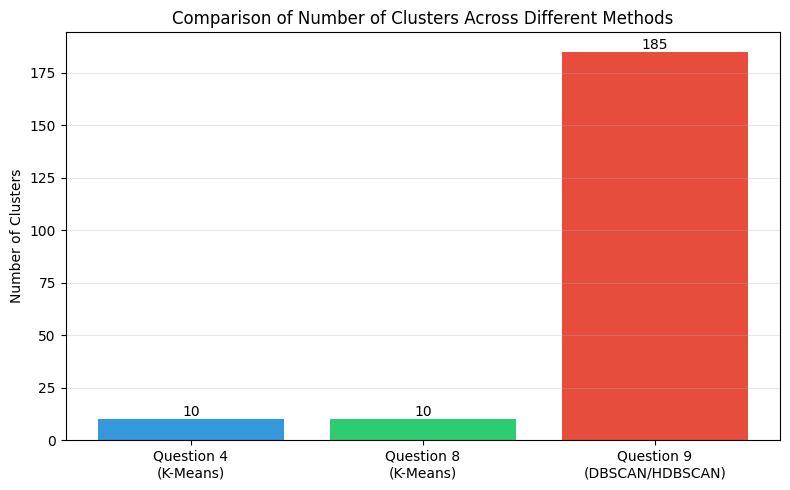

In [46]:
# Compare the number of clusters with questions 4 and 8
print(f"Question 4 (K-Means with elbow method): {optimal_k} clusters")
print(f"Question 8 (K-Means with elbow method): {optimal_k_8} clusters")
print(f"Question 9 (DBSCAN/HDBSCAN): {n_clusters_dbscan} clusters")

# Create comparison visualization
comparison_data = {
    'Method': ['Question 4\n(K-Means)', 'Question 8\n(K-Means)', 'Question 9\n(DBSCAN/HDBSCAN)'],
    'Number of Clusters': [optimal_k, optimal_k_8, n_clusters_dbscan]
}

comparison_df = pd.DataFrame(comparison_data)

plt.figure(figsize=(8, 5))
bars = plt.bar(comparison_df['Method'], comparison_df['Number of Clusters'], color=['#3498db', '#2ecc71', '#e74c3c'])
plt.ylabel('Number of Clusters')
plt.title('Comparison of Number of Clusters Across Different Methods')
plt.grid(axis='y', alpha=0.3)

# Add value labels on bars
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{int(height)}',
             ha='center', va='bottom')

plt.tight_layout()
plt.show()

In [47]:
# Add DBSCAN cluster labels to DataFrame for analysis
df_dbscan = df.copy()
df_dbscan['cluster_dbscan'] = labels_dbscan

# Analyze cluster distribution
cluster_counts = pd.Series(labels_dbscan).value_counts().sort_index()
print("\nCluster Distribution:")
print(cluster_counts.head(20))  # Show first 20 clusters

# Calculate percentage of points in each cluster (excluding noise)
valid_clusters = cluster_counts[cluster_counts.index != -1]
if len(valid_clusters) > 0:
    print(f"\nValid clusters: {len(valid_clusters)}")
    print(f"Noise points (outliers): {cluster_counts.get(-1, 0)} ({cluster_counts.get(-1, 0)/len(labels_dbscan)*100:.2f}%)")


Cluster Distribution:
-1     65750
 0       567
 1       173
 2       204
 3        59
 4       169
 5       113
 6       163
 7       163
 8        55
 9       158
 10      250
 11      132
 12      568
 13      132
 14       50
 15      326
 16      193
 17       58
 18       48
Name: count, dtype: int64

Valid clusters: 185
Noise points (outliers): 65750 (57.68%)


# Question 10

Κουράστηκα!